<a href="https://colab.research.google.com/github/xqyn/gamlss/blob/main/repli_GAMLSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Replica of Dinga et. al

PLEASE FIND THE ORIGINAL GITHUB LINK IN:
https://github.com/dinga92/gamlss_normative_paper

This is just a clone of the link above with slightly changes for colab

code accomponaying a paper

https://www.biorxiv.org/content/10.1101/2021.06.14.448106v1.full

In [1]:
%%capture
# Or clone from github:
! git clone https://github.com/xqyn/R-lib/

In [2]:
# For using R within python
%load_ext rpy2.ipython

In [3]:
%%R
#.libPaths("usr/local/lib/R/site-library/") # if clone from saved  lib in ggdrive
.libPaths('/content/R-lib/') # from github

In [4]:
%%R 
.libPaths()

[1] "/content/R-lib"                "/usr/local/lib/R/site-library"
[3] "/usr/lib/R/site-library"       "/usr/lib/R/library"           


In [5]:
%%script echo skipping
%%R
# For saving installed packages and loading wihout install again in furture (for Colab)
tar("library.tar.gz", "/usr/local/lib/R/site-library") # pack gamlss.dist
tar("library1.tar.gz", "/usr/lib/R/library") # pack MASS

skipping


In [6]:
%%script echo skipping
%cp library.tar.gz /content/drive/MyDrive/Colab/R/gamlss #cp to drive
%cp library1.tar.gz /content/drive/MyDrive/Colab/R/gamlss1 #cp to drive
# Pack MASS and gamlss.dist to R-lib

skipping


In [7]:
%%script echo skipping
# or install manually
%%R
install.packages('gamlss.dist', dependencies = TRUE)

skipping


In [8]:
%%capture
%%R
library(mgcv)
library(reshape2)
library(ggplot2)
library(cowplot)
library(patchwork)
library(viridis)
library(gamlss.dist)

In [9]:
%%capture
%%R
sessionInfo()

In [10]:
%%R
n <- 4000
x <- seq(0, 100, length.out = n)
sigmas <- 0.5 + 1.5*seq(from = -1, to = 1, length.out = n)**2
y  <- 50 + 0.15*x - 0.003*(x**2) + rSHASHo2(n = n, sigma = sigmas,   nu=-1.5, tau=1)

df1 <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')

In [11]:
%%R
m1 <- gam(list(y ~ x, # basically the same model as lm(y~x, data=df1)
                   ~ 1), 
            family=gaulss(),
            data=df1)

m2 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ 1), # fit sigma only as an intercept
            family=gaulss(),
            data=df1)

m3 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x)), # fit sigma as a smooth function of x
            family=gaulss(),
            data=df1)

m4 <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                   ~ s(x), # fit sigma as a smooth function of x
                   ~ 1, # fit nu (skewness) as an intercept
                   ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df1)

In [12]:
%%R
predictions_params_m1 <- predict(m1, newdata = df1)
predictions_params_m2 <- predict(m2, newdata = df1)
predictions_params_m3 <- predict(m3, newdata = df1)
predictions_params_m4 <- predict(m4, newdata = df1)

In [13]:
%%R
#Function
params_to_quantiles_norm <- function(quantiles, params){
  as.data.frame(sapply(quantiles, 
      function(q){
        qnorm(p=q, mean=params[,1], sd = exp(params[,2]))
      }))
}


params_to_quantiles_shash <- function(quantiles, params, qshash){
  as.data.frame(sapply(quantiles, 
      function(q){
        qshash(p=q, 
               # param is called mu, but it expects 
               # a vector of all 4 shash parameters
               mu=params)
      }))
}



In [14]:
%%R

quantiles <- pnorm(c(-2:2))
qshash <- m4$family$qf

predictions_quantiles_m1 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m1)
predictions_quantiles_m2 <- params_to_quantiles_norm(quantiles,
                                                     predictions_params_m2)
predictions_quantiles_m3 <- params_to_quantiles_norm(quantiles, 
                                                     predictions_params_m3)
predictions_quantiles_m4 <- params_to_quantiles_shash(quantiles, 
                                                      predictions_params_m4,
                                                      qshash)

reshape_quantiles_to_long <- function(quantiles_df, x_var){
  quantiles_df$x <- x_var
  return(reshape2::melt(quantiles_df, id.vars = c('x')))
}

predictions_quantiles_m1_long <- reshape_quantiles_to_long(predictions_quantiles_m1, df1$x)
predictions_quantiles_m2_long <- reshape_quantiles_to_long(predictions_quantiles_m2, df1$x)
predictions_quantiles_m3_long <- reshape_quantiles_to_long(predictions_quantiles_m3, df1$x)
predictions_quantiles_m4_long <- reshape_quantiles_to_long(predictions_quantiles_m4, df1$x)

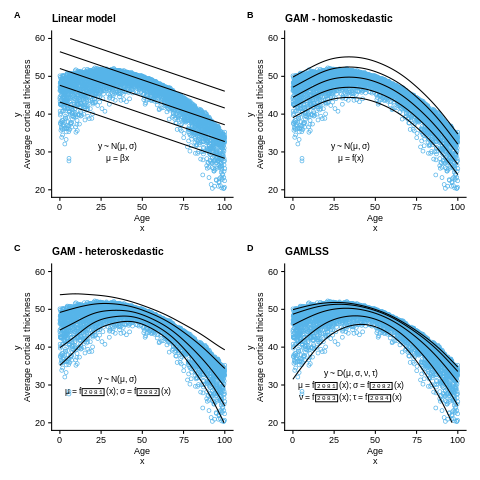

In [15]:
%%R
p1 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m1_long, aes(x=x, y=value, group=variable)) +
  labs(title='Linear model',
       # subtitle='Mean of y is modeled as a linear function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = βx") +
  ylim(c(20,60));

p2 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m2_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - homoskedastic',
       # subtitle='Mean of y is modeled as a smooth function of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f(x)") +
  ylim(c(20,60))

p3 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m3_long, aes(x=x, y=value, group=variable)) +
  labs(title='GAM - heteroskedastic',
       # subtitle='Mean and variance of y are modeled\nas smooth funcitons of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  +
  annotate("text", x = 35, y = 30, size=3,
              label = "y ~ N(μ, σ)\nμ = f₁(x); σ = f₂(x)") +
  ylim(c(20,60))

p4 <- ggplot(df1) +
  geom_point(aes(x=x, y=y), color='#56B4E9', shape=21) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable)) +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age\nx', 
       y='y\nAverage cortical thickness')  + 
  annotate("text", x = 35, y = 30, size=3,
           label = "y ~ D(μ, σ, ν, τ)\nμ = f₁(x); σ = f₂(x)\nν = f₃(x); τ = f₄(x)") +
  ylim(c(20,60))+
  theme_minimal(); 


p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=9),
                  axis.text = element_text(size=9)); p_all

# ggsave('fig_lm_to_gamls.png',
#        p_all, width = 5, height = 5, units = 'in')

In [16]:
%%R
k <- 100
x<-df1$x
y<-df1$y

contour_cols <- viridis(k, alpha = 0.5)
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

dens <- get_density(x, y, k)
def.par<-par()
#contour_cols

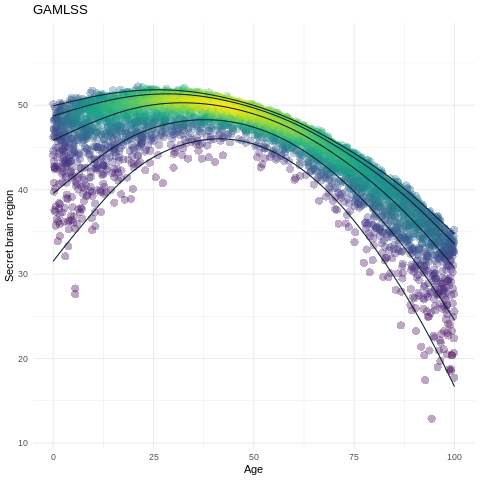

In [17]:
%%R
options(repr.plot.width = 2, repr.plot.height = 40, repr.plot.res = 100)
ggplot(df1) +
  geom_point(aes(x=x, y=y), 
             col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
             pch = 16, 
             alpha = .35,
             size=3.5) +
  geom_line(data=predictions_quantiles_m4_long, 
            aes(x=x, y=value, group=variable),
            color='#082133') +
  labs(title='GAMLSS',
       # subtitle='Location, scale, and shape\nare modeled as functions of x',
       x = 'Age', 
       y='Secret brain region')  + 
  annotate("text", x = 35, y = 60, size=8,
           label = expression(paste(
             'y ~ D(',mu,',',sigma,',',nu,',',tau,')',
             )))+
  ylim(c(min(y)*0.9,max(y)*1.1))+
  theme_minimal()

# Stupid Function

In [58]:
%%R
params_to_quantiles_norm <- function(quantiles, params){
  as.data.frame(sapply(quantiles, 
                       function(q){
                         qnorm(p=q, mean=params[,1], sd = exp(params[,2]))
                       }))
}


params_to_quantiles_shash <- function(quantiles, params, qshash){
  as.data.frame(sapply(quantiles, 
                       function(q){
                         qshash(p=q, 
                                # param is called mu, but it expects 
                                # a vector of all 4 shash parameters
                                mu=params)
                       }))
}
get_density <- function(x, y, n = 100) {
  dens <- MASS::kde2d(x = x, y = y, n = n)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}


xq_gamlss_stupid_func <- function(number_of_data, 
                                  intercept,
                                  B1,
                                  B2,
                                  skewness, 
                                  kurtosis, 
                                  density){
  n <- number_of_data
  x <- seq(0, 100, length.out = n)
  sigmas <- 0.5 + 1.5*seq(from = -1, to = 1, length.out = n)**2
  y  <- intercept + B1*x - B2*(x**2) + rSHASHo2(n = n, sigma = sigmas, nu=skewness, tau=kurtosis)
  df <- data.frame('x' = x, 'y' = y, 'dataset'='Training site')
  model <- gam(list(y ~ s(x), # fit mu as a smooth function of x
                 ~ s(x), # fit sigma as a smooth function of x
                 ~ 1, # fit nu (skewness) as an intercept
                 ~ 1), # fit tau (kurtosis) as an intercept
            family=shash(), # shash distribution instead of gaussian 
            data=df)
  predictions_params_model <- predict(model, newdata = df)
  quantiles <- pnorm(c(-2:2))
  qshash <- model$family$qf
  predictions_quantiles_model <- params_to_quantiles_shash(quantiles, 
                                                        predictions_params_model,
                                                        qshash)
  reshape_quantiles_to_long <- function(quantiles_df, x_var){
    quantiles_df$x <- x_var
    return(reshape2::melt(quantiles_df, id.vars = c('x')))}
  predictions_quantiles_model_long <- reshape_quantiles_to_long(predictions_quantiles_model, df$x)
  k <- density
  x<-df$x
  y<-df$y
  contour_cols <- viridis(k, alpha = 0.5)
  dens <- get_density(x, y, k)
  ## 2. Generating plots -----
  def.par<-par()
  p_xq<- ggplot(df) +
    geom_point(aes(x=x, y=y), 
               col = contour_cols[findInterval(dens, seq(0, max(dens), length.out = k))], 
               pch = 16, 
               alpha = .35,
               size=3.5) +
    geom_line(data=predictions_quantiles_model_long, 
              aes(x=x, y=value, group=variable),
              color='#082133') +
    labs(title=expression(paste('GAMLSS | y ~ D(',mu,',',sigma,',',nu,',',tau,') ')),
         subtitle = paste0('intercept = ', intercept,
                         ', β1 = ', B1,
                         ', β2 = ', B2),
         # subtitle='Location, scale, and shape\nare modeled as functions of x',
         x = 'Age',
         y='Secret brain region')  + 
    annotate("text", x = 80, y = max(y)+5, size=4,
             label = paste(
               '\nSkewness =', skewness,
               '\nKurtosis =', kurtosis
             ))+
    ylim(c(min(y)*0.9,max(y)*1.1))+
    theme_minimal(); 
  }


#plot <- xq_gamlss_stupid_func(number_of_data = ,
#                                 intercept = ,
#                                 B1 = ,
#                                 B2 = ,
#                                 skewness = ,
#                                 kurtosis = ,
#                                 density = )

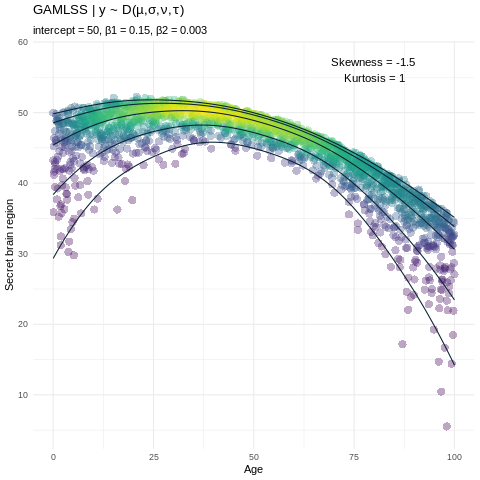

In [60]:
%%R
p1 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1.5,1,100)
p1

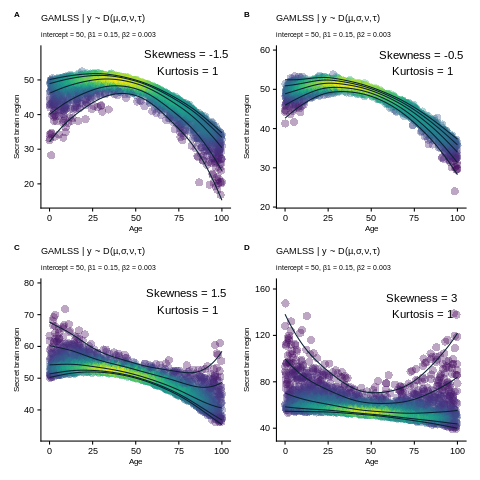

In [61]:
%%R
# Look at skewness
p1 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1.5,1,100)
p2 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-0.5,1,100)
p3 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,1.5,1,100)
p4 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,3,1,100)
p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
                  axis.text = element_text(size=9)); p_all

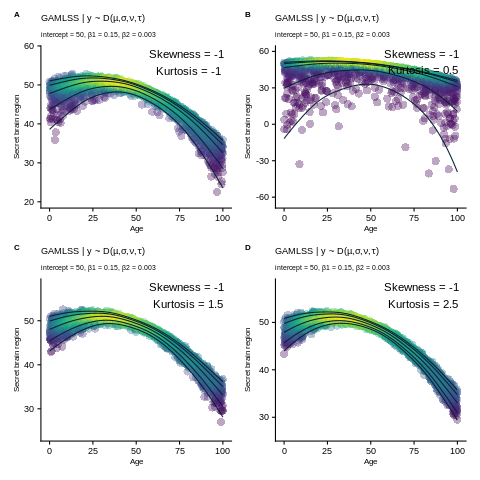

In [62]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1,-1,100)
p2 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1,0.5,100)
p3 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1,1.5,100)
p4 <- xq_gamlss_stupid_func(2000,50,0.15,0.003,-1,2.5,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all

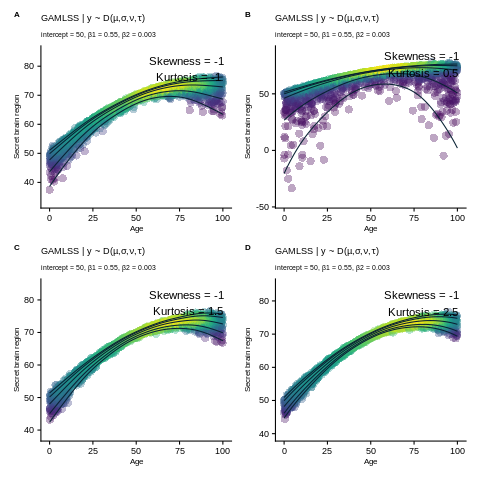

In [63]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,50,0.55,0.003,-1,-1,100)
p2 <- xq_gamlss_stupid_func(2000,50,0.55,0.003,-1,0.5,100)
p3 <- xq_gamlss_stupid_func(2000,50,0.55,0.003,-1,1.5,100)
p4 <- xq_gamlss_stupid_func(2000,50,0.55,0.003,-1,2.5,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all

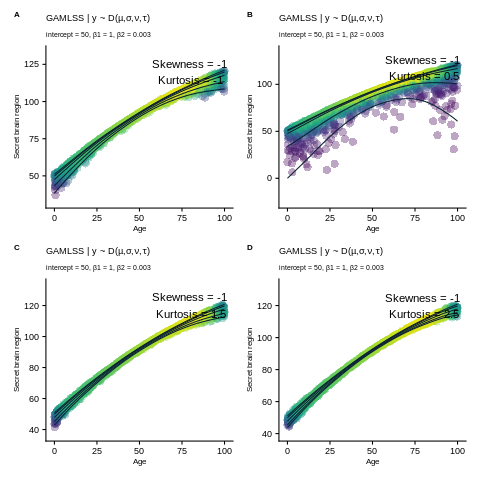

In [64]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,50,1,0.003,-1,-1,100)
p2 <- xq_gamlss_stupid_func(2000,50,1,0.003,-1,0.5,100)
p3 <- xq_gamlss_stupid_func(2000,50,1,0.003,-1,1.5,100)
p4 <- xq_gamlss_stupid_func(2000,50,1,0.003,-1,2.5,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all

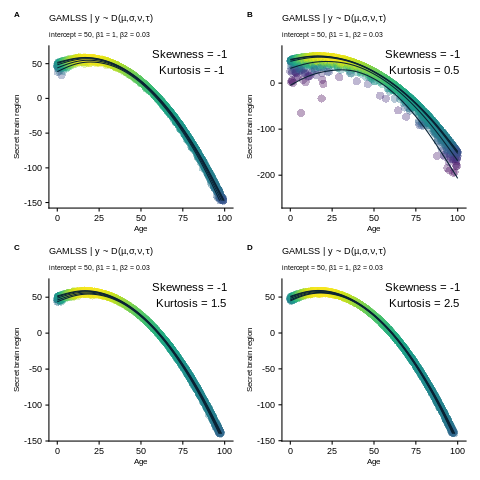

In [65]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,50,1,0.03,-1,-1,100)
p2 <- xq_gamlss_stupid_func(2000,50,1,0.03,-1,0.5,100)
p3 <- xq_gamlss_stupid_func(2000,50,1,0.03,-1,1.5,100)
p4 <- xq_gamlss_stupid_func(2000,50,1,0.03,-1,2.5,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all

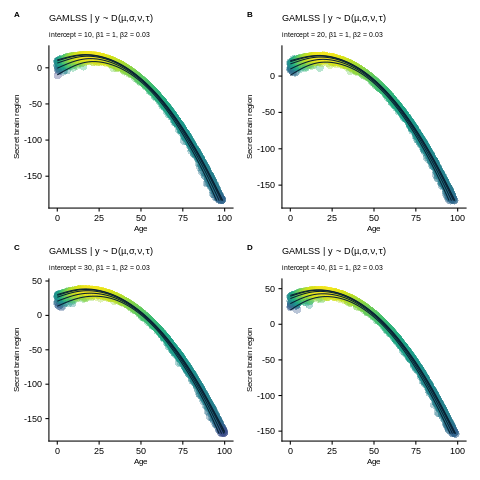

In [66]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,10,1,0.03,-1.5,1,100)
p2 <- xq_gamlss_stupid_func(2000,20,1,0.03,-1.5,1,100)
p3 <- xq_gamlss_stupid_func(2000,30,1,0.03,-1.5,1,100)
p4 <- xq_gamlss_stupid_func(2000,40,1,0.03,-1.5,1,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all

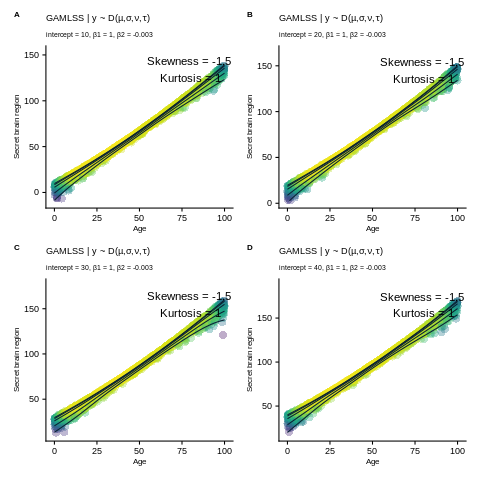

In [67]:
%%R
# Look at Kurtosis
# Kurtosis must #0

p1 <- xq_gamlss_stupid_func(2000,10,1,-0.003,-1.5,1,100)
p2 <- xq_gamlss_stupid_func(2000,20,1,-0.003,-1.5,1,100)
p3 <- xq_gamlss_stupid_func(2000,30,1,-0.003,-1.5,1,100)
p4 <- xq_gamlss_stupid_func(2000,40,1,-0.003,-1.5,1,100)

p_all <- p1 + p2 + p3 + p4 + 
  plot_annotation(tag_levels = 'A') & 
  theme_cowplot() &
  theme(text=element_text(size=8),
        axis.text = element_text(size=9)); p_all